# Graphiques et Corrélations Variables Officielles

## Import des packages et des données

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import time
from tqdm import tqdm

In [3]:
conso = pd.read_csv('Ressources/Consommation des ménages trimestrielle.csv',sep=';')
consof = pd.read_csv('Ressources/Consommation par fonction.csv',sep=';')
consot = pd.read_csv('Ressources/Consommation.csv',sep=';')
retail_trade = pd.read_csv('Ressources/Retail trade index.csv',sep=';').drop(range(4)).reset_index().drop('index',axis=1)
retail_trade = retail_trade.rename({'Titre :':'Date'},axis='columns').set_index('Date').replace({',':'.'},regex=True).astype('float64')

In [4]:
retail_brut = retail_trade.loc[:,[column.endswith('(Brut)') for column in retail_trade.columns]]
retail_CJO_CVS = retail_trade.loc[:,[column.endswith('(CJO CVS)') for column in retail_trade.columns]]

In [5]:
retail_brut_valeur = retail_brut.filter(regex='indice en valeur')
retail_brut_volume = retail_brut.filter(regex='indice en volume')
retail_CJO_CVS_valeur = retail_CJO_CVS.filter(regex='indice en valeur')
retail_CJO_CVS_volume = retail_CJO_CVS.filter(regex='indice en volume')

In [6]:
consof = consof.filter(regex='Série CVS-CJO',axis=1)
consot = consot.set_index('Libellé').filter(regex='Série CVS-CJO').drop('idBank').drop('Période')

In [7]:
var = []
for i in range(4,len(consot),1):
    var.append(float(consot.iloc[::-1].iloc[i]/consot.iloc[::-1].iloc[i-4] - 1))
yty_var = pd.DataFrame({'Variations de la consommation':var,
'Date':list(consot.iloc[::-1].index)[4:]})
yty_var = yty_var.set_index('Date')

## Graphiques simples

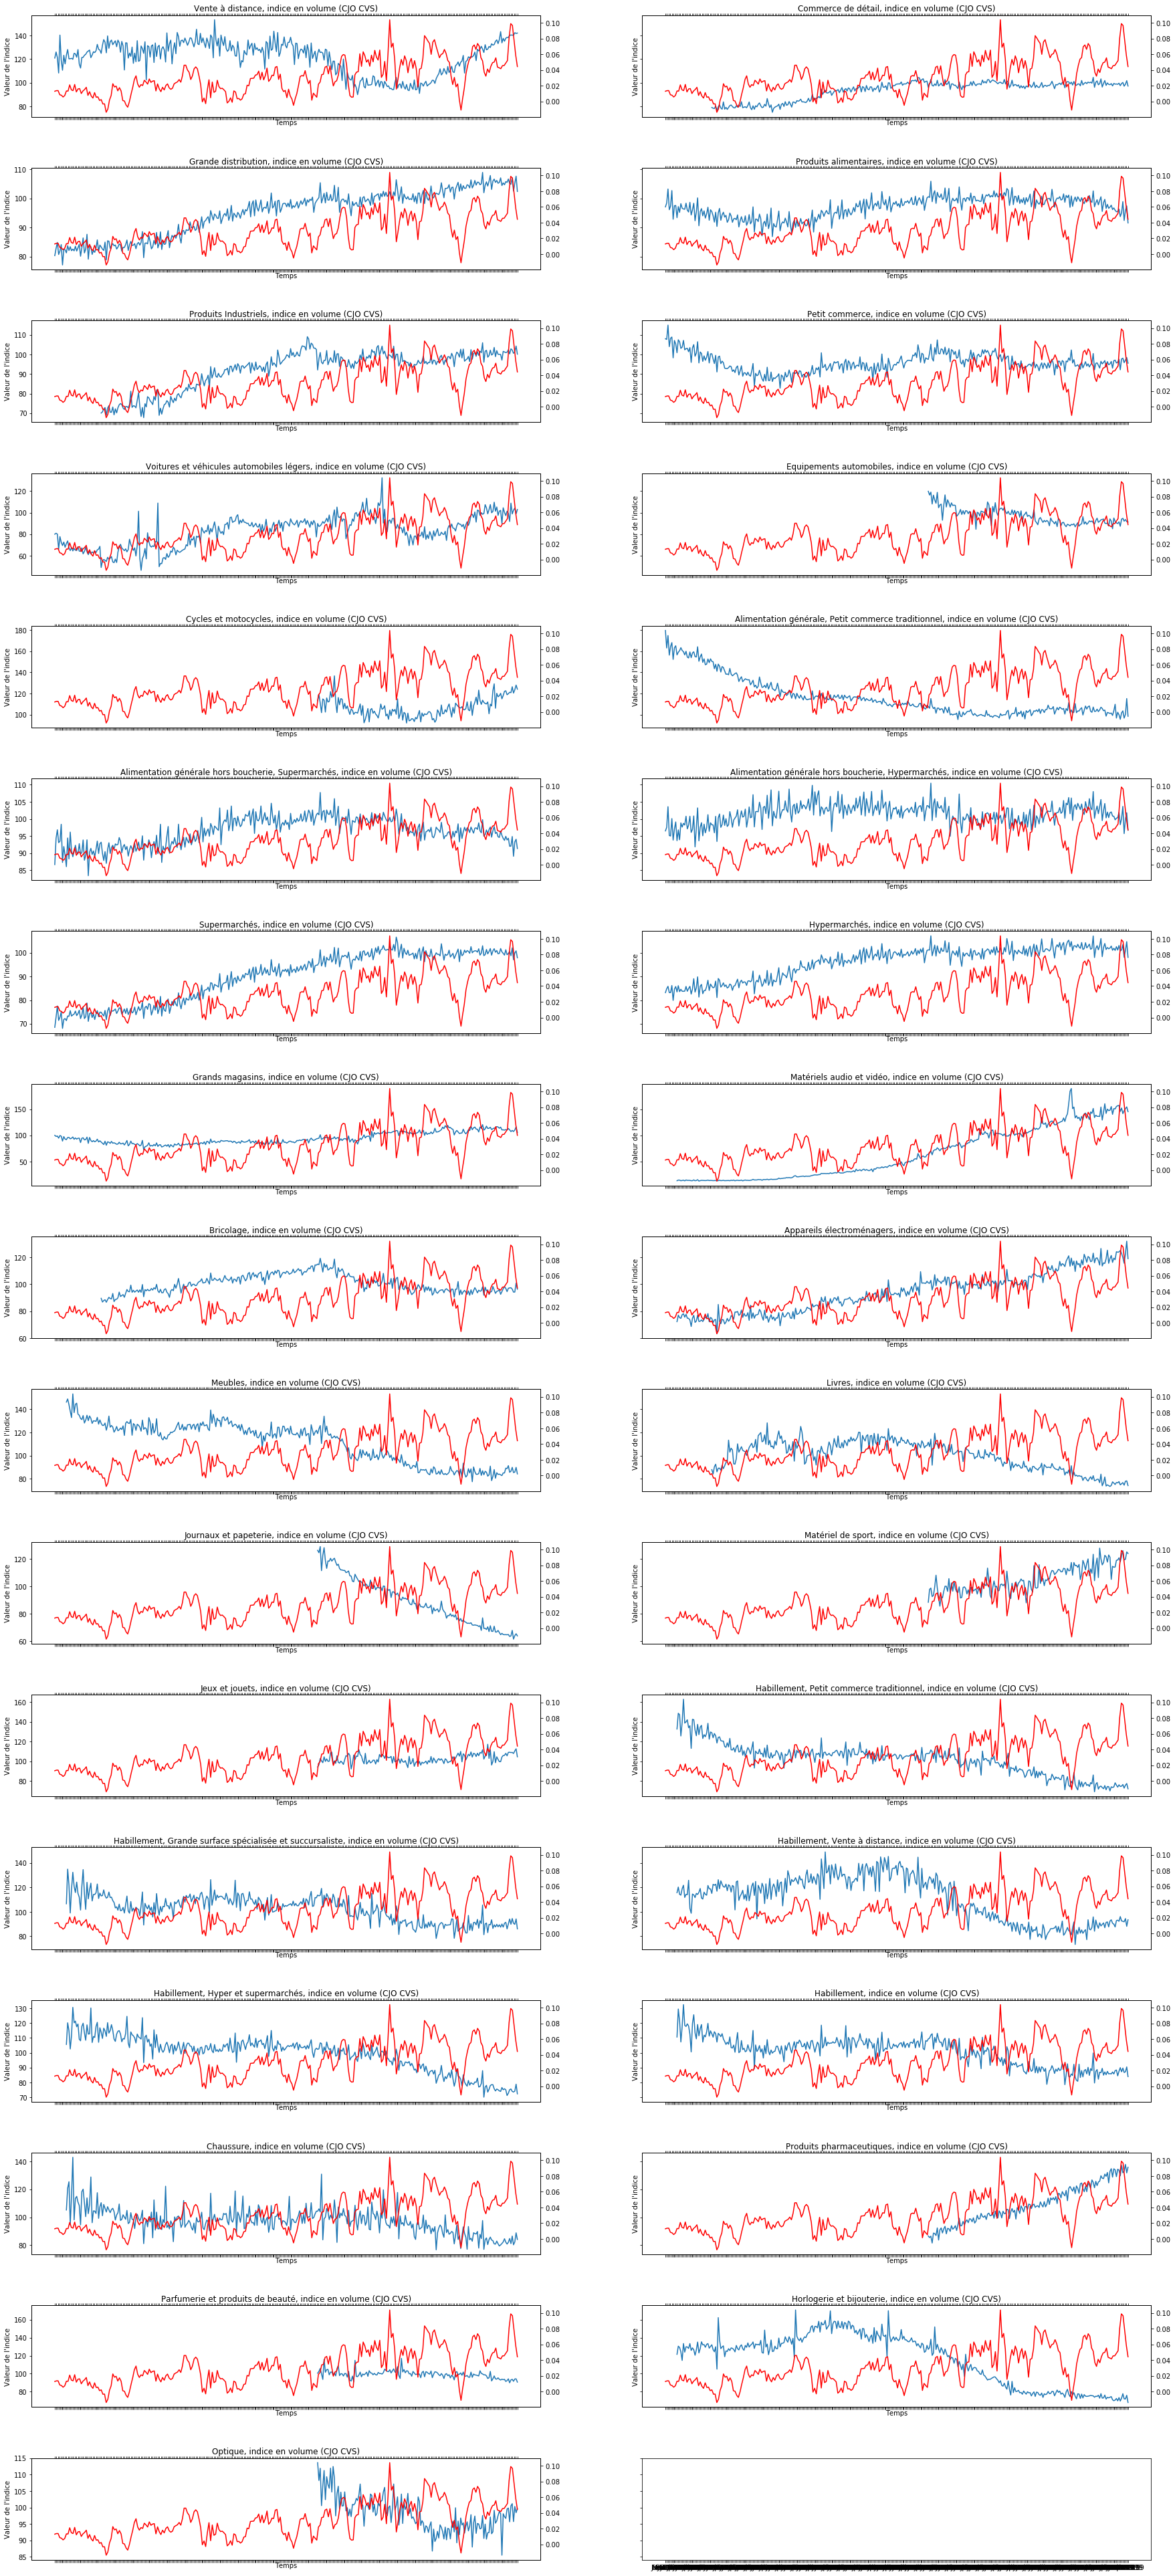

In [23]:
plt.rcParams['figure.figsize'] = [30,70]

fig_retail_CJO_CVS_volume, axs_volume_CJO_CVS = plt.subplots(len(retail_CJO_CVS_volume.columns)//2+1,2,sharex='col',sharey='row',gridspec_kw={'wspace':0.2,'hspace':0.5})

for i in range(len(retail_CJO_CVS_volume.columns)):
    axs_volume_CJO_CVS[i//2][i%2].plot(retail_CJO_CVS_volume.iloc[::-1,i])
    axs_volume_CJO_CVS[i//2][i%2].set(title=retail_CJO_CVS_volume.columns[i])
    axs_volume_CJO_CVS[i//2][i%2].set_xlabel('Temps')
    axs_volume_CJO_CVS[i//2][i%2].set_ylabel('Valeur de l\'indice')
    plt.setp(axs_volume_CJO_CVS[i//2][i%2].get_xticklabels(), visible=False)

    ax_twin = axs_volume_CJO_CVS[i//2][i%2].twinx().twiny()
    ax_twin.plot(yty_var,color='r')
    ax_twin.set_ylabel('Consommation des ménages')
    plt.setp(ax_twin.get_xticklabels(), visible=False)

plt.savefig('Graphiques Retail.png')

## Pearson correlation
$corr(x,y) = \frac{Cov(x,y)}{\sigma(x)\sigma(y)}$

On commence par calculer la moyenne par trimestre des indices.

In [ ]:
dictionnaire = {}

for col in retail_CJO_CVS_volume.columns:
    dictionnaire[col]=[]
    for i in range(int(len(retail_CJO_CVS_volume)/4)):
        dictionnaire[col].append(retail_CJO_CVS_volume[col][i*4:(i+1)*4].mean())

trimestre = pd.DataFrame(dictionnaire)
trimestre['Libellé']=pd.Series()
for i in range(len(trimestre)):
    trimestre['Libellé'][i]=str(2019-i//4)+'-T'+str(4-i%4)

trimestre = trimestre.set_index('Libellé')

In [ ]:
yty_var = yty_var.reset_index().rename(columns={'Date':'Libellé'}).set_index('Libellé')

In [ ]:
plt.rcParams['figure.figsize'] = (20,7)
fig_pearson_corr, ax_pearson_corr = plt.subplots()

x = range(len(trimestre.columns))

ax_pearson_corr.bar(x,yty_var.loc['1997-T3':].reset_index().merge(trimestre.reset_index(),on='Libellé').set_index('Libellé').corr().loc['Variations de la consommation'][1:].T.values)

plt.xticks(x,yty_var.loc['1997-T3':].reset_index().merge(trimestre.reset_index(),on='Libellé').set_index('Libellé').corr().loc['Variations de la consommation'][1:].T.index)

plt.setp(ax_pearson_corr.get_xticklabels(),rotation=45,ha='right',rotation_mode='anchor')

plt.savefig('Correlations Retail.png',bbox_inches = 'tight')

## Time-lagged cross-correlations
On veut:

1. Checker les dates de publications de la conso (ainsi que leurs **lags**) et des indices
2. Checker la correlation entre une moyenne d'indice au quarter i-1 avec la conso au quarter i
3. Checker la correlation entre l'indice du mois précédent le quarter en question et la conso sur ce quarter
4. Checker la correlation entre l'indice du 1e mois du quarter (resp 2e, 3e, 4e) et la conso sur ce quarter
5. Auto-régresser (juste la conso puis VAR) aux ordres 1,2,3,4.


### Corrélations entre conso à la date t et indice (moyenne trimestrielle) à la date t-1

In [ ]:
yty_var.loc['1997-T2':].reset_index().merge(trimestre.reset_index(),on='Libellé').set_index('Libellé').corr().loc['Variations de la consommation'][1:]

In [ ]:
plt.rcParams['figure.figsize'] = (20,7)
fig_pearson_corr_lag1, ax_pearson_corr_lag1 = plt.subplots()

x = range(len(trimestre.columns))

ax_pearson_corr_lag1.bar(x,yty_var.loc['1997-T3':].reset_index().merge(trimestre.reset_index(),on='Libellé').set_index('Libellé').corr().loc['Variations de la consommation'][1:].T.values)

plt.xticks(x,yty_var.loc['1997-T3':].reset_index().merge(trimestre.reset_index(),on='Libellé').set_index('Libellé').corr().loc['Variations de la consommation'][1:].T.index)

plt.setp(ax_pearson_corr_lag1.get_xticklabels(),rotation=45,ha='right',rotation_mode='anchor')

plt.savefig('Correlations Retail Lag1.png',bbox_inches = 'tight')

Idée : 

* Reploter les deux derniers graphiques sur un seul graphique pour comparer l'évolution des corrélations.
* Indiquer les maxs et les mins
    

### Corrélations avec le mois précédent le trimestre

On commence par construire une df qui indique la valeur de l'indice au mois précédent le trimestre en question.

Décembre doit prédire T1, Septembre T4, Juin prédit T3, Mars prédit T2.

In [ ]:
yty_var = yty_var[::-1]

In [ ]:
trimestre_prec = retail_CJO_CVS_volume.iloc[range(0,len(retail_CJO_CVS_volume),3)]
trimestre_prec = trimestre_prec[1:]
trimestre_prec = trimestre_prec.set_index(yty_var.loc[:'1990-T2'].index)

In [ ]:
yty_var.reset_index().merge(trimestre_prec.reset_index(),on='Libellé').set_index('Libellé').corr()[1:]['Variations de la consommation']

In [ ]:
plt.rcParams['figure.figsize'] = (20,7)
fig_pearson_corr_lag2, ax_pearson_corr_lag2 = plt.subplots()

x = range(len(trimestre_prec.columns))

ax_pearson_corr_lag2.bar(x,yty_var.reset_index().merge(trimestre_prec.reset_index(),on='Libellé').set_index('Libellé').corr()[1:]['Variations de la consommation'].values)

plt.xticks(x,yty_var.reset_index().merge(trimestre_prec.reset_index(),on='Libellé').set_index('Libellé').corr()[1:]['Variations de la consommation'].index)

plt.setp(ax_pearson_corr_lag2.get_xticklabels(),rotation=45,ha='right',rotation_mode='anchor')

plt.savefig('Correlations Retail Lag2.png',bbox_inches = 'tight')